# 📈 Tuned LSTM Stock Movement Predictor

This notebook loads stock price data, creates technical indicators, prepares the data for LSTM, builds a tuned LSTM model, and evaluates its performance.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import ta  # Technical Analysis library

In [23]:
# Load dataset
df = pd.read_csv("a.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Add technical indicators
df['rsi'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['macd'] = ta.trend.MACD(df['Close']).macd()
df['ema'] = ta.trend.EMAIndicator(df['Close']).ema_indicator()

# Create features & target
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'macd', 'ema']
data = df[features]

In [24]:
# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(df['target'].values[i])
X = np.array(X)
y = np.array(y)

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

In [26]:
# LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.5072 - loss: 0.6943 - val_accuracy: 0.5030 - val_loss: 0.6949
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4982 - loss: 0.6940 - val_accuracy: 0.5030 - val_loss: 0.6949
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.5008 - loss: 0.6944 - val_accuracy: 0.5030 - val_loss: 0.6933
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5059 - loss: 0.6933 - val_accuracy: 0.5030 - val_loss: 0.6934
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5011 - loss: 0.6933 - val_accuracy: 0.5030 - val_loss: 0.6939
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 51s 552ms/step - accuracy: 0.5117 - loss: 0.6927 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.4850 - loss: 0.6940 - val_accuracy: 0.4970 - val_loss: 0.6939
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5130 - loss: 0.6933 - val_accuracy: 0.5030 - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Accuracy: 0.5030211480362538
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       329
           1       0.50      1.00      0.67       333

    accuracy                           0.50       662
   macro avg       0.25      0.50      0.33       662
weighted avg       0.25      0.50      0.34       662



C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

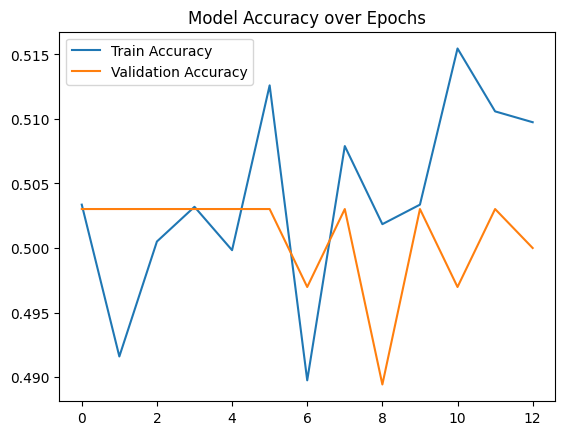

In [ ]:
# Evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy over Epochs')
plt.show()

In [28]:
def predict_tomorrow_movement(model, scaler):
    # ✍️ Manually input today's values
    open_price = 243.8
    high_price = 249.2
    low_price = 240.7
    close_price = 244.3
    volume = 1234567

    # Technical indicators – dummy values or real ones you compute
    rsi = 51.2
    macd = 0.5
    ema = 245.1

    # Combine in the same order as used during training
    input_features = np.array([[open_price, high_price, low_price, close_price,
                                volume, rsi, macd, ema]])

    # Scale the input
    input_scaled = scaler.transform(input_features)

    # Reshape for LSTM (3D): We have 1 sample, 60 timesteps, and 8 features.
    # Since we have only one data point, we'll repeat it across the 60 timesteps.
    input_scaled = np.repeat(input_scaled, 60, axis=0)  # Repeat the input for 60 timesteps
    input_scaled = input_scaled.reshape((1, 60, input_scaled.shape[1]))  # Shape: (1, 60, 8)

    # Predict
    prediction = model.predict(input_scaled)
    result = int(prediction[0] > 0.5)

    # Output
    print("\n📈 Prediction for Tomorrow:")
    print("➡️  Price expected to go UP 📈" if result == 1 else "⬅️  Price expected to go DOWN 📉")

# Call the prediction function after training
predict_tomorrow_movement(model, scaler)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

📈 Prediction for Tomorrow:
⬅️  Price expected to go DOWN 📉


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_39616\1557592171.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = int(prediction[0] > 0.5)
